In [1]:
import pandas as pd
import pymc_marketing as pmm
import matplotlib as mpl
import matplotlib.pyplot as plt
from cabm import post_processing as ppr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Figure setup
# Set the font to Courier
mpl.rcParams['font.family'] = 'Courier'

# Set the line weight to thin
mpl.rcParams['lines.linewidth'] = 0.75

# Set the color scheme to black and white
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['axes.edgecolor'] = 'black'

In [3]:
agent_df = pd.read_pickle('agent_output_A_ADS_ONLY.pkl')

In [4]:
agent_df = ppr.add_date_column(agent_df)

In [5]:
data_A = ppr.calculate_total_purchases(agent_df, ['price_A','tv_A','web_A', 'price_B', 'tv_B', 'web_B'])


In [6]:
data_A = ppr.add_total_sales_columns(data_A)

In [7]:
data_A = ppr.ensure_float_columns(data_A, exclude_columns=['Date','Step'])

In [8]:
data_a_mod = data_A[52:].reset_index(drop=True)

In [11]:
data_a_mod['Total_Sales_A'] = data_a_mod['Total_Sales_A'] * 1000
data_a_mod['Total_Sales_B'] = data_a_mod['Total_Sales_B'] * 1000


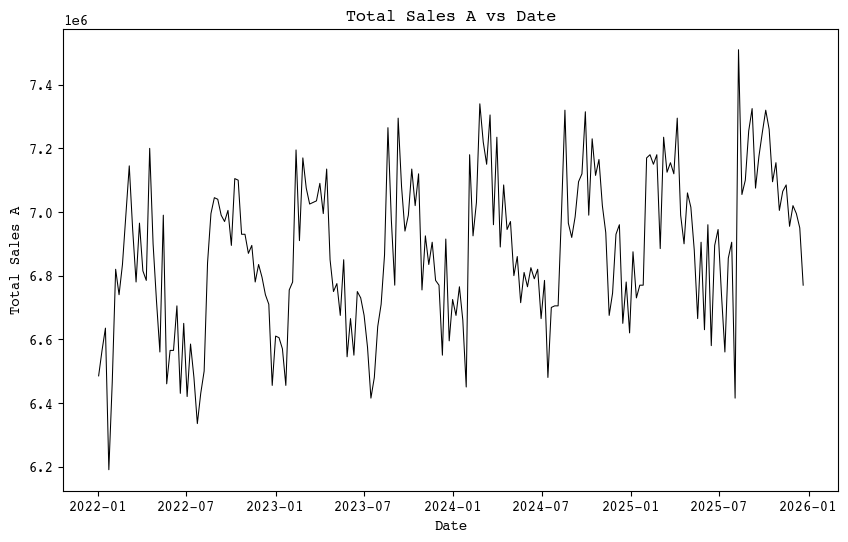

In [16]:
plt.figure(figsize=(10,6))
plt.plot(data_a_mod['Date'], data_a_mod['Total_Sales_A'],color='black')
plt.xlabel('Date')
plt.ylabel('Total Sales A')
plt.title('Total Sales A vs Date')
plt.show()


In [13]:
data_a_mod.to_csv("sim_data_trunc.csv", index=False)

In [24]:
# Define the columns
date_column = 'Date'
channel_columns = ['tv_A', 'web_A']

my_sampler_config = {
    'tune': 1000,
    'draws': 1000,
    'chains': 4,
    #'target_accept': 0.9  # Increase this value to increase target_accept
}

# Instantiate the model
mmm = pmm.mmm.delayed_saturated_mmm.DelayedSaturatedMMM(
    sampler_config=my_sampler_config,
    date_column=date_column,
    channel_columns=channel_columns,
    control_columns=None,
    adstock_max_lag=8,
)

In [25]:
# Split data into predictors (X) and target (y)
X = data_a_mod.drop('Total_Sales_A', axis=1)
y = data_a_mod['Total_Sales_A']

# Fit the model
mmm.fit(X, y)

/Users/michael/.venvs/pymmm_0_6_0/lib/python3.12/site-packages/pymc/model/core.py:518: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
/Users/michael/.venvs/pymmm_0_6_0/lib/python3.12/site-packages/pymc/model/core.py:988: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
/Users/michael/.venvs/pymmm_0_6_0/lib/python3.12/site-packages/pymc/data.py:304: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_channel, alpha, lam, likelihood_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [26]:
import arviz as az
import pymc as pm
import seaborn as sns

In [27]:
mmm.fit_result

<xarray.Dataset> Size: 29MB
Dimensions:                    (chain: 4, draw: 1000, channel: 2, date: 130)
Coordinates:
  * chain                      (chain) int64 32B 0 1 2 3
  * draw                       (draw) int64 8kB 0 1 2 3 4 ... 996 997 998 999
  * channel                    (channel) <U5 40B 'tv_A' 'web_A'
  * date                       (date) datetime64[ns] 1kB 2023-07-02 ... 2025-...
Data variables:
    alpha                      (chain, draw, channel) float64 64kB 0.08216 .....
    beta_channel               (chain, draw, channel) float64 64kB 0.005778 ....
    channel_adstock            (chain, draw, date, channel) float64 8MB 0.0 ....
    channel_adstock_saturated  (chain, draw, date, channel) float64 8MB 0.0 ....
    channel_contributions      (chain, draw, date, channel) float64 8MB 0.0 ....
    intercept                  (chain, draw) float64 32kB 0.9109 ... 0.9062
    lam                        (chain, draw, channel) float64 64kB 3.682 ... ...
    likelihood_sigma           (chain, draw) float64 32kB 0.02893 ... 0.02804
    mu                         (chain, draw, date) float64 4MB 0.9109 ... 0.9062
Attributes:
    created_at:                 2024-06-14T01:57:04.159534+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1
    sampling_time:              4.170644998550415
    tuning_steps:               1000

In [28]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "alpha",
        "lam",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.913,0.003,0.907,0.920,0.000,0.000,2198.0,1809.0,1.0
likelihood_sigma,0.031,0.002,0.028,0.035,0.000,0.000,3259.0,2626.0,1.0
beta_channel[tv_A],0.032,0.057,0.000,0.085,0.002,0.001,1250.0,1506.0,1.0
beta_channel[web_A],0.051,0.085,0.000,0.142,0.003,0.002,1142.0,1091.0,1.0
alpha[tv_A],0.384,0.260,0.000,0.819,0.006,0.004,1927.0,2004.0,1.0
alpha[web_A],0.556,0.262,0.061,0.923,0.006,0.005,1842.0,2040.0,1.0
lam[tv_A],2.430,1.726,0.072,5.579,0.031,0.022,1981.0,1369.0,1.0
lam[web_A],2.582,1.798,0.069,5.695,0.033,0.023,1973.0,1679.0,1.0


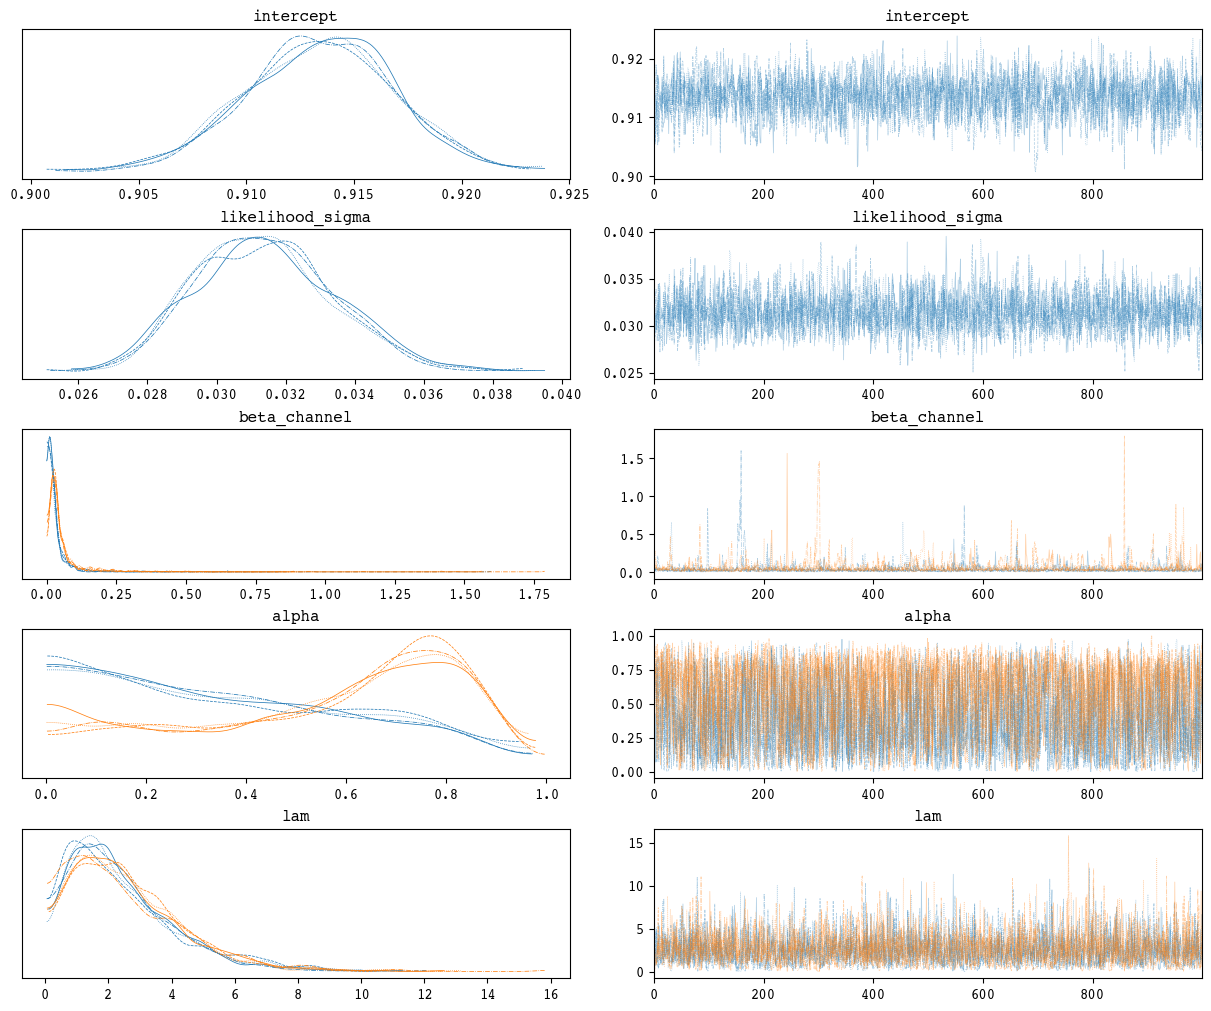

In [29]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "likelihood_sigma",
        "beta_channel",
        "alpha",
        "lam",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)

In [30]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

Sampling: [y]


Output()

<xarray.Dataset> Size: 4MB
Dimensions:  (date: 130, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2023-07-02 2023-07-09 ... 2025-12-21
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 4MB 3.57e+03 3.721e+03 ... 3.753e+03
Attributes:
    created_at:                 2024-06-14T01:57:11.013796+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1

/Users/michael/.venvs/pymmm_0_6_0/lib/python3.12/site-packages/sklearn/utils/deprecation.py:129: FutureWarning: Xt was renamed X in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/michael/.venvs/pymmm_0_6_0/lib/python3.12/site-packages/sklearn/utils/deprecation.py:129: FutureWarning: Xt was renamed X in version 1.5 and will be removed in 1.7.
  warnings.warn(


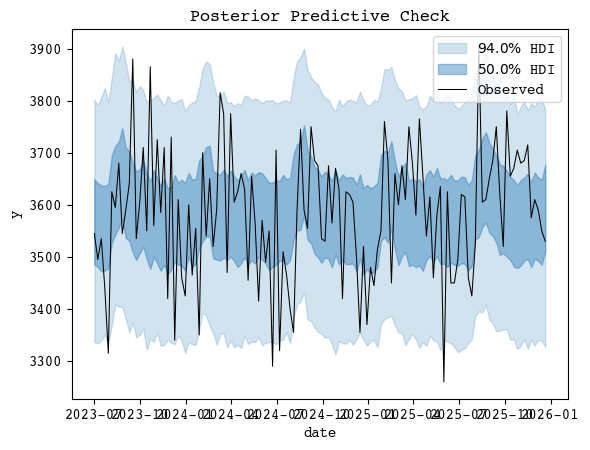

In [31]:
mmm.plot_posterior_predictive(original_scale=True);

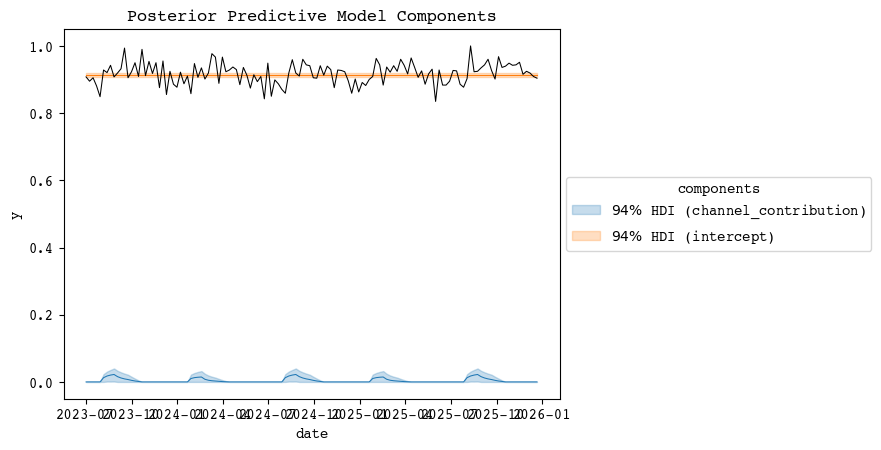

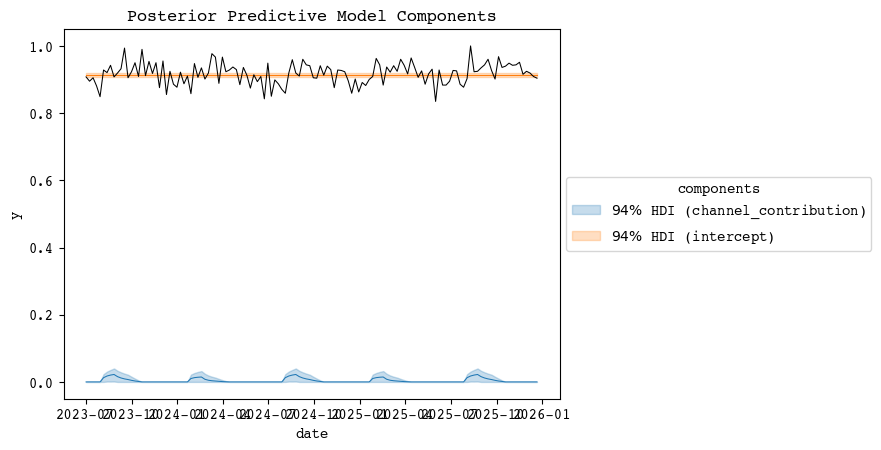

In [32]:
mmm.plot_components_contributions()

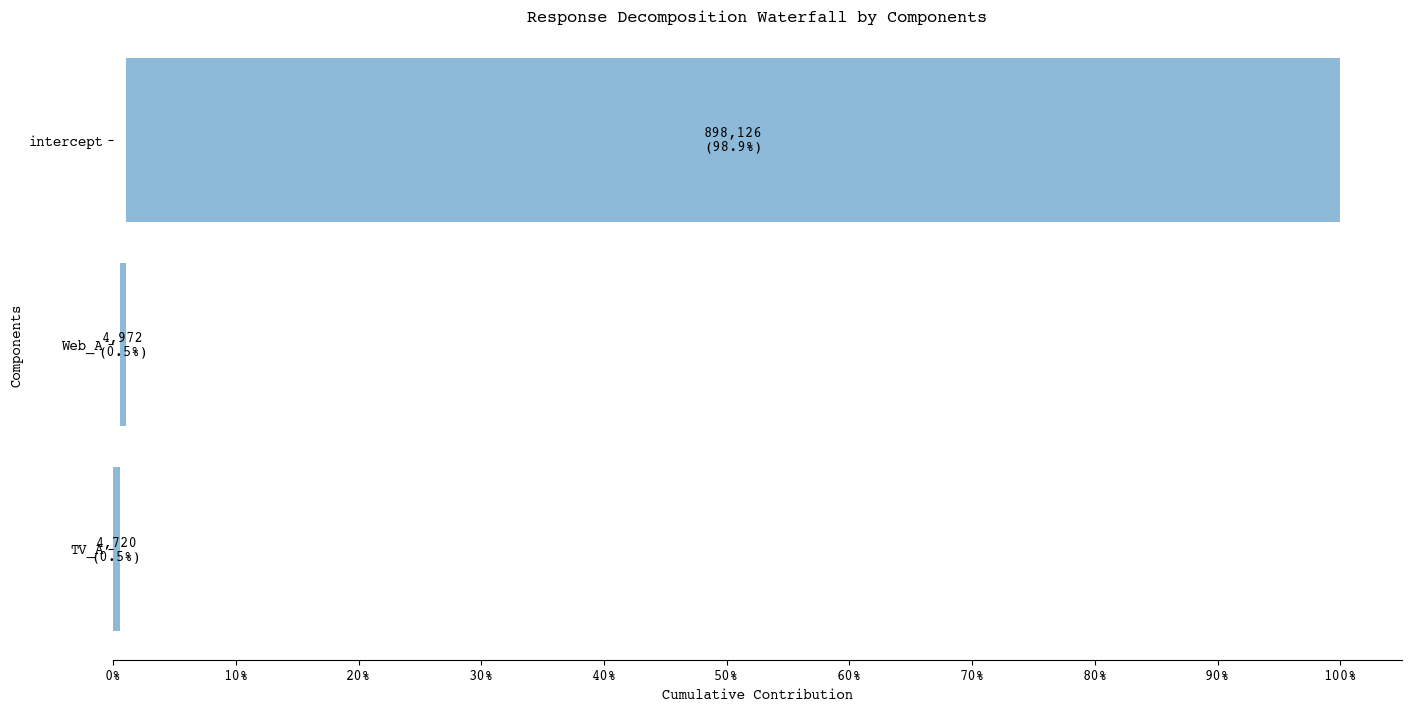

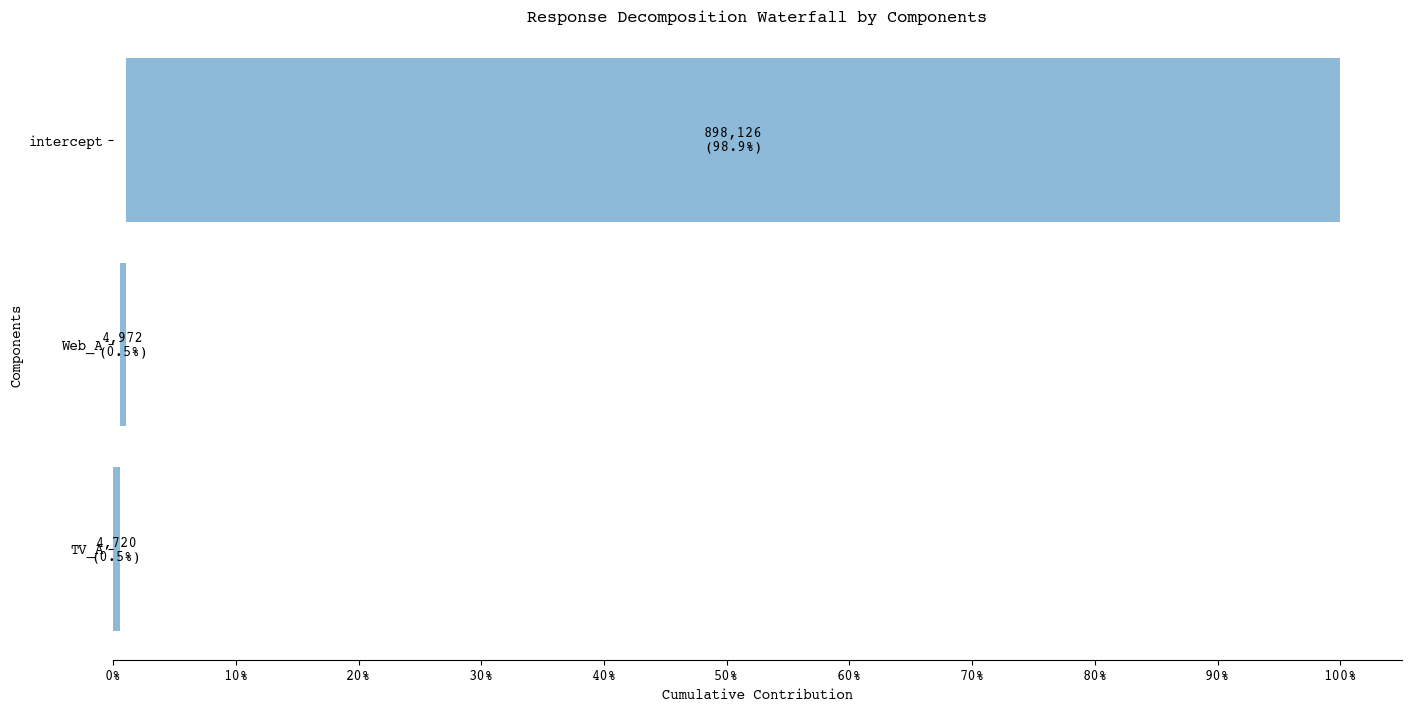

In [63]:
mmm.plot_waterfall_components_decomposition()

In [29]:
import pprint

In [30]:
dummy_model = DelayedSaturatedMMM(date_column="", channel_columns="", adstock_max_lag=4)
pprint.pprint(dummy_model.default_model_config)

{'alpha': {'dist': 'Beta', 'kwargs': {'alpha': 1, 'beta': 3}},
 'beta_channel': {'dist': 'HalfNormal', 'kwargs': {'sigma': 2}},
 'gamma_control': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'gamma_fourier': {'dist': 'Laplace', 'kwargs': {'b': 1, 'mu': 0}},
 'intercept': {'dist': 'Normal', 'kwargs': {'mu': 0, 'sigma': 2}},
 'lam': {'dist': 'Gamma', 'kwargs': {'alpha': 3, 'beta': 1}},
 'likelihood': {'dist': 'Normal',
                'kwargs': {'sigma': {'dist': 'HalfNormal',
                                     'kwargs': {'sigma': 2}}}}}
